In [1]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from modules import dataset, vqvae

physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

Load the data from dataset.

In [2]:
data_train, data_validate, data_test = dataset.load_data()
print(len(data_train))
print(len(data_validate))
print(len(data_test))

9664
1120
544


Create image generator to pass to the vqvae model for training.

In [3]:
data_gen = dataset.data_generator(train_data = data_train)
validate_gen = dataset.validate_generator(validate_data = data_validate)

In [4]:
img= next(data_gen)
print(img.shape)
img = next(validate_gen)
print(img.shape)
print(len(data_train))
print(len(data_validate))

(8, 256, 256, 1)
(8, 256, 256, 1)
9664
1120


In [5]:
steps_per_epoch = len(data_train)/8
valiation_steps = len(data_validate)/8
print(steps_per_epoch)
print(valiation_steps)

1208.0
140.0


Train the VQVAE model.

In [6]:
vqvae_trainer = vqvae.VQVAE(latent_dim=256, num_embeddings=256)
vqvae_trainer.compile(optimizer=keras.optimizers.Adam())
history = vqvae_trainer.fit(data_gen, epochs = 20, validation_data = validate_gen, batch_size = 8, 
                    validation_steps = valiation_steps, validation_batch_size = 8, steps_per_epoch = steps_per_epoch)

Epoch 1/20
1208/1208 [==============================] - 64s 52ms/step - total_loss: 0.0490 - reconstruction_loss: 0.0052 - vq_loss: 0.0438 - val_total_loss: 0.0059 - val_reconstruction_loss: 0.0025 - val_vq_loss: 0.0034
Epoch 2/20
1208/1208 [==============================] - 64s 53ms/step - total_loss: 0.0049 - reconstruction_loss: 0.0021 - vq_loss: 0.0028 - val_total_loss: 0.0043 - val_reconstruction_loss: 0.0020 - val_vq_loss: 0.0024
Epoch 3/20
1208/1208 [==============================] - 64s 53ms/step - total_loss: 0.0037 - reconstruction_loss: 0.0017 - vq_loss: 0.0020 - val_total_loss: 0.0035 - val_reconstruction_loss: 0.0017 - val_vq_loss: 0.0018
Epoch 4/20
1208/1208 [==============================] - 64s 53ms/step - total_loss: 0.0031 - reconstruction_loss: 0.0014 - vq_loss: 0.0017 - val_total_loss: 0.0031 - val_reconstruction_loss: 0.0013 - val_vq_loss: 0.0018
Epoch 5/20
1208/1208 [==============================] - 65s 54ms/step - total_loss: 0.0029 - reconstruction_loss: 0.0012

Plot some results of the model(original image vs. reconstructed image outputs from the model) 

In [9]:
from modules import tools

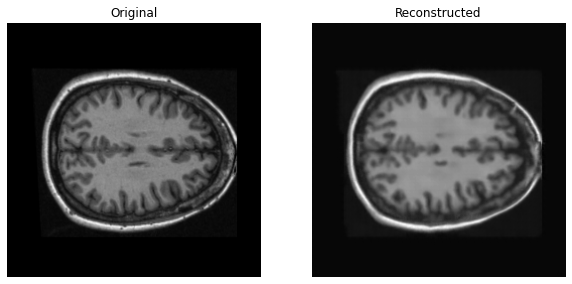

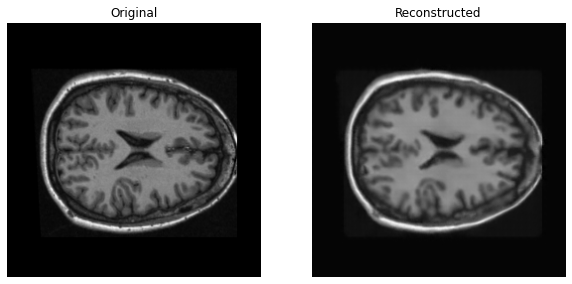

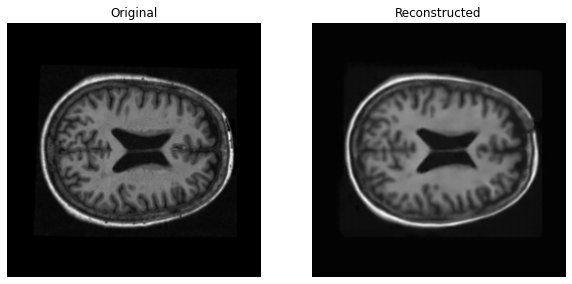

In [10]:
img_count = 3
tools.plot_images(img_count, data_test, vqvae_trainer)